### Linear Model Tree

### Importing the relevant libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pytz
import time

import plotly.express as px
from scipy import stats

mpl.rcParams['figure.figsize'] = (18,12)
mpl.rcParams['axes.grid'] = False
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
sns.set()
sns.set_style('whitegrid')

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

### Features of the data 

https://climate.weather.gc.ca/glossary_e.html#s <br>

$\textit{timestamp: }$ The date along with the time of the day the data was collected  <br>
$\textit{unixtime: }$ A system for describing a point in time <br>
$\textit{pressure_station: }$ The true pressure of the location recorded at the station in kilopascals (kPa) <br>
$\textit{pressure_sea: }$ The pressure at sea level in kilopascals (kPa) <br>
$\textit{wind_dir: }$ The direction of the wind <br>
$\textit{wind_dir_10: }$ Represented in 10s of degrees <br>
$\textit{wind_speed: }$ Speed of the motion of air in kilometres per hour (km/h) <br>
$\textit{wind_gust: }$ Sudden burst in wind speed in kilometres per hour (km/h) usually lasts for 20 seconds or under <br>
$\textit{relative_humidity: }$ Describes the amount of water vapour held in the air <br>
$\textit{dew_point: }$ The temperature in Celsius to which the air must be cooled before dew or frost begins to form  <br>
$\textit{temperature: }$ The current temperature of the air recorded at the station in Celsius <br>
$\textit{windchill: }$ Wind chill is an index to indicate how cold the weather feels to the average person <br>
$\textit{humidex: }$ Humidex is an index to indicate how hot or humid the weather feels to the average person <br>
$\textit{visibility: }$ Visibility in kilometres (km) is the distance at which objects of suitable size can be seen <br>
$\textit{health_index: }$ Scale designed to help you understand what the air quality around you means to your health <br>
$\textit{cloud_cover_4: }$ Measures the cloud cover <br>
$\textit{cloud_cover_8: }$ Measures the cloud cover <br>
$\textit{cloud_cover_10: }$ Measures the cloud cover <br>
$\textit{solar_radiation: }$ Solar radiation is the measurement of radiant energy from the sun <br>
$\textit{max_air_temp_pst1hr: }$ Maximum air temperature in the past one hour <br>
$\textit{min_air_temp_pst1hr: }$ Minimum air temperature in the past one hour <br>
$\textit{demand: }$ The electrical demand on hourly basis for the city of Toronto (MWhr) <br>

In [2]:
data = pd.read_csv('Data/Toronto_data.csv')
display(data.head())

timestamp    unixtime  pressure_station  pressure_sea wind_dir  \
0  2017-01-01 00  1483246800             98.67        100.79        W   
1  2017-01-01 01  1483250400             98.83        100.95        W   
2  2017-01-01 02  1483254000             98.95        101.08        W   
3  2017-01-01 03  1483257600             99.14        101.27        W   
4  2017-01-01 04  1483261200             99.28        101.41        W   

   wind_dir_10s  wind_speed  wind_gust  relative_humidity  dew_point  ...  \
0          26.0        35.0       45.0               69.0       -4.5  ...   
1          26.0        35.0        NaN               70.0       -4.5  ...   
2          26.0        32.0       43.0               67.0       -5.4  ...   
3          26.0        28.0        NaN               69.0       -5.1  ...   
4          26.0        27.0        NaN               69.0       -5.1  ...   

   humidex  visibility  health_index  cloud_cover_4  cloud_cover_8  \
0      NaN     24100.0           NaN            NaN            7.0   
1      NaN     24100.0           NaN            NaN            7.0   
2      NaN     24100.0           2.3            NaN            7.0   
3      NaN     24100.0           2.3            NaN            7.0   
4      NaN     24100.0           2.2            NaN            7.0   

   cloud_cover_10  solar_radiation  max_air_temp_pst1hr  min_air_temp_pst1hr  \
0             NaN              NaN                  0.9                  0.3   
1             NaN              NaN                  0.6                  0.2   
2             NaN              NaN                  0.3                 -0.1   
3             NaN              NaN                  0.0                 -0.2   
4             NaN              NaN                 -0.1                 -0.3   

   demand  
0    5665  
1    5665  
2    5665  
3    5665  
4    5665  

[5 rows x 22 columns]

I am particularly interested in predicting the electrical demand data. Temperature of the surrounding air, for obvious reasons, affects the electrical demand. We can drop the remaining columns and use the date_time_local as a datetime object to index the data frame.

In [3]:
data.drop(['unixtime','pressure_station','pressure_sea','wind_dir', 'wind_dir_10s', 'wind_gust','dew_point',
           'windchill','visibility', 'health_index', 'cloud_cover_4', 'cloud_cover_10', 'solar_radiation',
            'humidex','max_air_temp_pst1hr','min_air_temp_pst1hr','relative_humidity','wind_speed','cloud_cover_8']
          ,axis=1,inplace=True)

display(data.head())
display(data.shape)

timestamp  temperature  demand
0  2017-01-01 00          0.5    5665
1  2017-01-01 01          0.3    5665
2  2017-01-01 02          0.0    5665
3  2017-01-01 03         -0.1    5665
4  2017-01-01 04         -0.1    5665

(35496, 3)

In [4]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

data_noindex = data.copy()
data = data.set_index('timestamp')

display(data.head())

temperature  demand
timestamp                               
2017-01-01 00:00:00          0.5    5665
2017-01-01 01:00:00          0.3    5665
2017-01-01 02:00:00          0.0    5665
2017-01-01 03:00:00         -0.1    5665
2017-01-01 04:00:00         -0.1    5665

### Handling missing values

Let's check the number of missing data points in the temperature and demand data. Looks like IESO has been doing a good job maintaing their demand data. They seem to have adjusted for missing data already. And there are only 7 missing data points in the temperature data too. We will fix these shortly.

In [5]:
display(pd.DataFrame({'Missing Values':data.isna().sum(),'Percentage':data.isna().sum()*100/data.shape[0]}))

Missing Values  Percentage
temperature               7    0.019721
demand                    0    0.000000

Let us take a look at the missing values in the temperature and fix them. We can observe that the missing values are not continuous and therefore, we could use forward fill to fill in these missing data points.

In [6]:
display(data.query('temperature != temperature'))

temperature  demand
timestamp                               
2017-06-10 01:00:00          NaN    4509
2017-11-08 12:00:00          NaN    5972
2018-07-07 01:00:00          NaN    4614
2018-07-07 02:00:00          NaN    4389
2018-09-09 04:00:00          NaN    3705
2019-05-13 19:00:00          NaN    6040
2020-06-11 00:00:00          NaN    5528

In [7]:
data['temperature'] = data['temperature'].fillna(method='ffill')
display(pd.DataFrame({'Missing Values':data.isna().sum(),'Percentage':data.isna().sum()*100/data.shape[0]}))

Missing Values  Percentage
temperature               0         0.0
demand                    0         0.0

### Defining relevant Functions

We split the data set into various categories based on the domain knowledge of factors affecting the electrical demand

$\textit{Temperature: }$ Based on the above analysis we split it into "Hot" (>15 degrees) and "NotHot" (<15 degrees) <br>
$\textit{Time of the day: }$ Split into "AwakeHours" (7am to 10pm) and "SleepHours" (10pm to 7am) <br>
$\textit{Type of the day: }$ Split into "Weekend" and "Weekday" <br> 
$\textit{Pandemic effects: }$ We can look at the information available at https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Ontario#Lifting_of_restrictions_after_the_first_wave to look at different stages of lockdown.

In [8]:
def temp_(x):
    """
    Divides the dataset into two categories based on the temperature
    """
    if x > 15:
        return 'Hot'
    else:
        return 'NotHot'

def peak_(x):
    """
    Divides the dataset into two categories based on the hour of the day
    """
    if x >= 7 and x <= 22:
        return 'AwakeHours'
    else: 
        return 'SleepHours'
    
def weekday_(x):
    """
    Divides the dataset into two categories based on the day of the week
    """
    if x >= 5:
        return 'Weekend'
    else:
        return 'Weekday'
    
def pandemic_(x):
    """
    Divides the dataset into multiple categories based on the type of lockdown imposed
    """
    if x >= datetime.date(2020,12,21):
        return 'FullLockdown'
    elif x >= datetime.date(2020,10,10):
        return 'ModifiedStageTwo'
    elif x >= datetime.date(2020,8,12):
        return 'StageThree'
    elif x >= datetime.date(2020,6,24):
        return 'StageTwo'
    elif x >= datetime.date(2020,5,20):
        return 'StageOne'
    elif x >= datetime.date(2020,3,17):
        return 'FullLockdown'  
    else:
        return 'NormalDay'
    
def dayofweek_(x):
    """
    Divides the dataset into seven categories based on the day of the week
    """
    if x == 0:
        return 'Monday'
    elif x == 1:
        return 'Tuesday'
    elif x == 2:
        return 'Wednesday'
    elif x == 3:
        return 'Thursday'
    elif x == 4:
        return 'Friday'
    elif x == 5:
        return 'Saturday'
    elif x == 6:
        return 'Sunday'

est = pytz.timezone('US/Eastern')
def dst_index(x):
    """
    Divides the dataset into two categories based on whether or not daylight savings is in place
    """
    if est.localize(x).dst().seconds == 0:
        return "NoDST"
    else:
        return "DST"

Extracting several relevant features from the data

In [9]:
data['year'] = data.index.year
data['month'] = data.index.month
data['dayofweek'] = data.index.dayofweek
data['day'] = data.index.day
data['hour'] = data.index.hour
data['temp_index'] = data['temperature'].apply(temp_)
data['hour_index'] = data['hour'].apply(peak_)
data['week_index'] = data['dayofweek'].apply(weekday_)
#data['day_index'] = data['dayofweek'].apply(dayofweek_)
#data['day_status'] = [pandemic_(x.date()) for x in data.reset_index()['timestamp']]
data['dst_index'] = [dst_index(x) for x in data.reset_index()['timestamp']]
display(data.head())

temperature  demand  year  month  dayofweek  day  hour  \
timestamp                                                                     
2017-01-01 00:00:00          0.5    5665  2017      1          6    1     0   
2017-01-01 01:00:00          0.3    5665  2017      1          6    1     1   
2017-01-01 02:00:00          0.0    5665  2017      1          6    1     2   
2017-01-01 03:00:00         -0.1    5665  2017      1          6    1     3   
2017-01-01 04:00:00         -0.1    5665  2017      1          6    1     4   

                    temp_index  hour_index week_index dst_index  
timestamp                                                        
2017-01-01 00:00:00     NotHot  SleepHours    Weekend     NoDST  
2017-01-01 01:00:00     NotHot  SleepHours    Weekend     NoDST  
2017-01-01 02:00:00     NotHot  SleepHours    Weekend     NoDST  
2017-01-01 03:00:00     NotHot  SleepHours    Weekend     NoDST  
2017-01-01 04:00:00     NotHot  SleepHours    Weekend     NoDST

### Holidays

Incorporating some of the public holidays and treating them as weekend

In [10]:
for year in list(data['year'].unique()):
    try:
        data.loc[str(year) + '-1-1','week_index'] = 'Weekend'
        data.loc[str(year) + '-7-1','week_index'] = 'Weekend'
        data.loc[str(year) + '-12-25','week_index'] = 'Weekend'
        data.loc[str(year) + '-12-26','week_index'] = 'Weekend'
    except:
        continue

### Exploratory Analysis

The other notebook "Analysis_ElectricityDemand" has a detailed analysis of various factors and its effects. In this we just revisit some of them quickly and plot them. It is a fair assumption to make that the electricity demand is strongly dependent on the temperature. In the plot below, we can see the relation between temperature and demand for various cases.

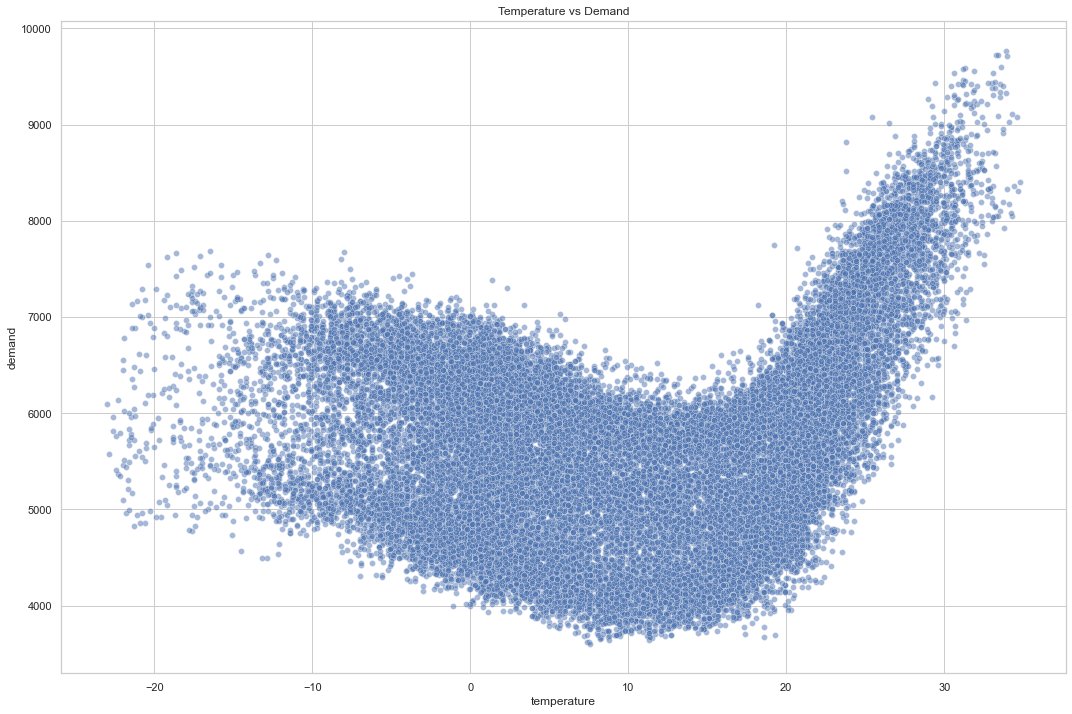

In [11]:
sns.scatterplot(x='temperature',y='demand',data=data,palette="mako", alpha = 0.5);
plt.title('Temperature vs Demand');

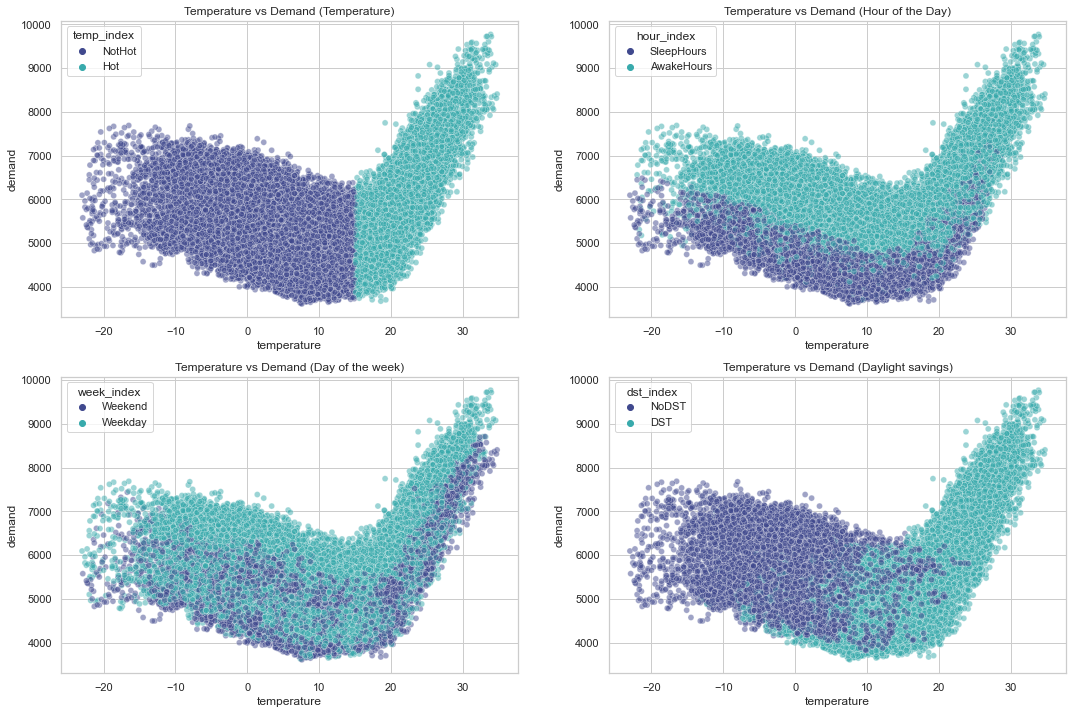

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2)

sns.scatterplot(x='temperature',y='demand',hue='temp_index',data=data,ax=axes[0,0],palette="mako", alpha = 0.5);
axes[0,0].set_title('Temperature vs Demand (Temperature)');
sns.scatterplot(x='temperature',y='demand',hue='hour_index',data=data,ax=axes[0,1],palette="mako", alpha = 0.5);
axes[0,1].set_title('Temperature vs Demand (Hour of the Day)');
sns.scatterplot(x='temperature',y='demand',hue='week_index',data=data,ax=axes[1,0],palette="mako", alpha = 0.5);
axes[1,0].set_title('Temperature vs Demand (Day of the week)');
sns.scatterplot(x='temperature',y='demand',hue='dst_index',data=data,ax=axes[1,1],palette="mako", alpha = 0.5);
axes[1,1].set_title('Temperature vs Demand (Daylight savings)');

### Linear Model Tree

As discussed in "Analysis_ElectricityDemand", we can see a positive relationship in the Hot category and a negative relationship in the NotHot category. We can further divide it into two categories based on whether it is awake hours or sleep hours. This way we have four categories that have individual linear relationship.

In [13]:
def sections(x,y):
    """
    Divides the dataset into four sections as discussed above
    """
    if x == 'AwakeHours' and y == 'Hot':
        return 'Section1'
    elif x == 'AwakeHours' and y == 'NotHot':
        return 'Section2'
    elif x == 'SleepHours' and y == 'NotHot':
        return 'Section3'
    elif x == 'SleepHours' and y == 'Hot':
        return 'Section4'

In [14]:
data['sections'] = data.apply(lambda x: sections(x['hour_index'],x['temp_index']), axis=1)
display(data.head())

temperature  demand  year  month  dayofweek  day  hour  \
timestamp                                                                     
2017-01-01 00:00:00          0.5    5665  2017      1          6    1     0   
2017-01-01 01:00:00          0.3    5665  2017      1          6    1     1   
2017-01-01 02:00:00          0.0    5665  2017      1          6    1     2   
2017-01-01 03:00:00         -0.1    5665  2017      1          6    1     3   
2017-01-01 04:00:00         -0.1    5665  2017      1          6    1     4   

                    temp_index  hour_index week_index dst_index  sections  
timestamp                                                                  
2017-01-01 00:00:00     NotHot  SleepHours    Weekend     NoDST  Section3  
2017-01-01 01:00:00     NotHot  SleepHours    Weekend     NoDST  Section3  
2017-01-01 02:00:00     NotHot  SleepHours    Weekend     NoDST  Section3  
2017-01-01 03:00:00     NotHot  SleepHours    Weekend     NoDST  Section3  
2017-01-01 04:00:00     NotHot  SleepHours    Weekend     NoDST  Section3

In each of the sections, we can now spot a linear relationship and the corresponding pearson coefficients are shown below.

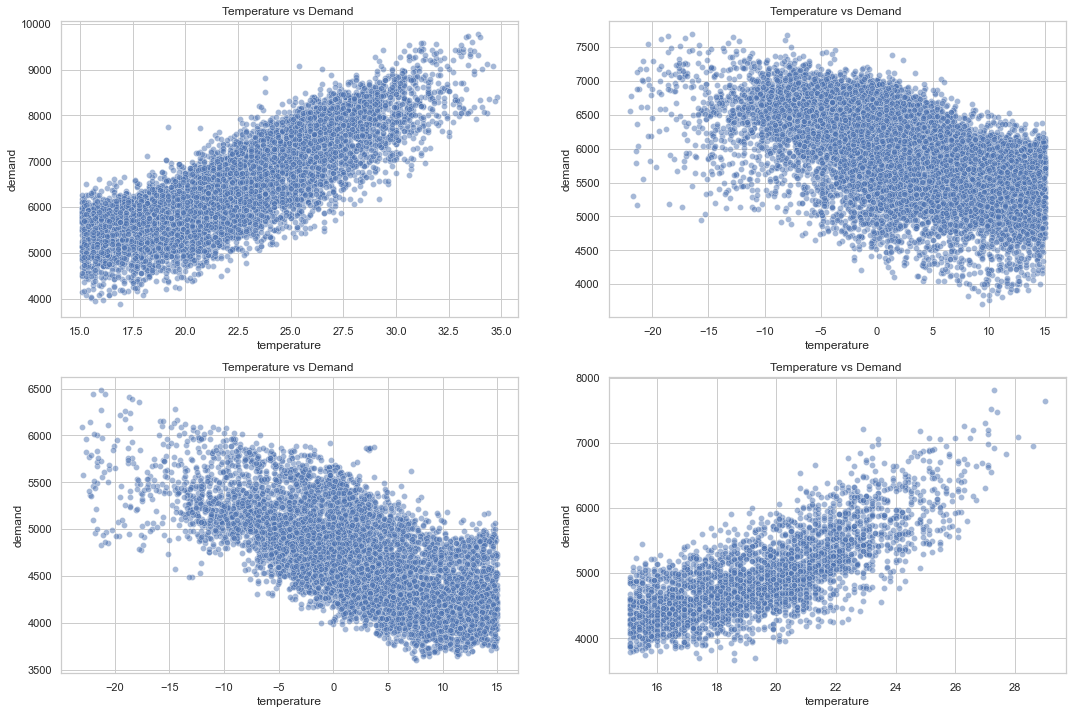

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2)

sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section1"'),ax=axes[0,0], alpha = 0.5);
axes[0,0].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section2"'),ax=axes[0,1], alpha = 0.5);
axes[0,1].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section3"'),ax=axes[1,0], alpha = 0.5);
axes[1,0].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section4"'),ax=axes[1,1], alpha = 0.5);
axes[1,1].set_title('Temperature vs Demand ');

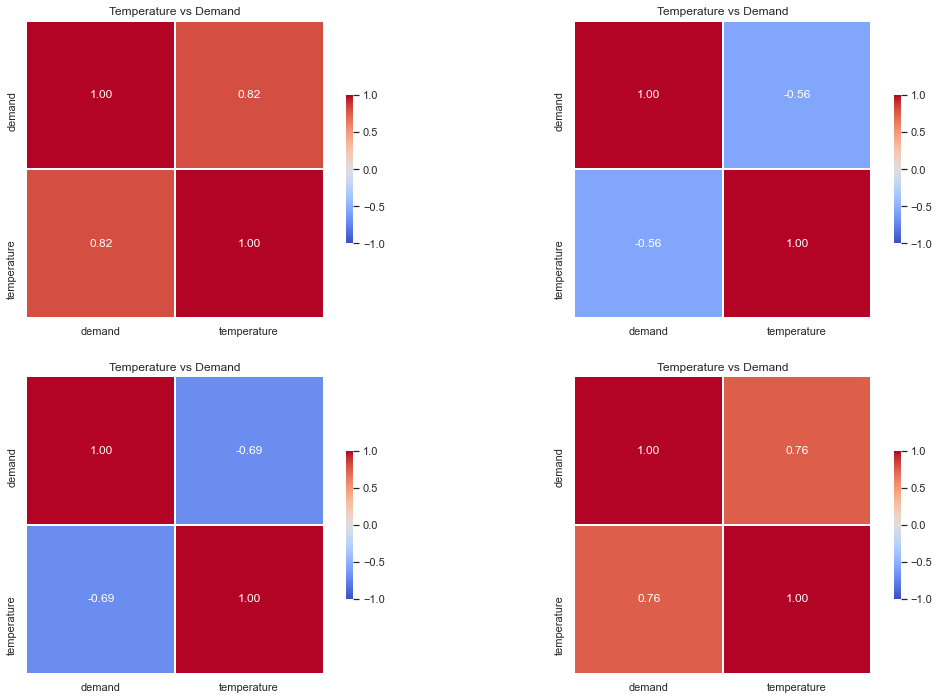

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2)

sns.heatmap(data.query('sections == "Section1"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.5}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0,0]);
axes[0,0].set_title('Temperature vs Demand');
sns.heatmap(data.query('sections == "Section2"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.5}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0,1]);
axes[0,1].set_title('Temperature vs Demand');
sns.heatmap(data.query('sections == "Section3"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.5}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1,0]);
axes[1,0].set_title('Temperature vs Demand');
sns.heatmap(data.query('sections == "Section4"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.5}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1,1]);
axes[1,1].set_title('Temperature vs Demand');

We can now split it further based on whether it is a weekend or weekday and we are going to end up with eight sections.

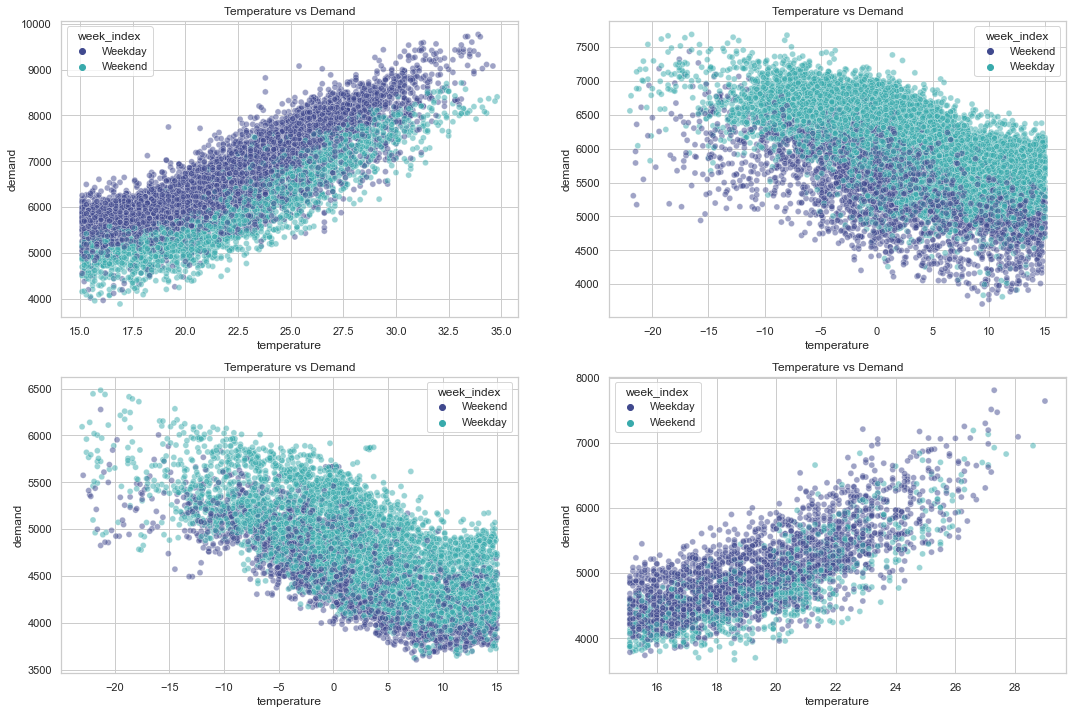

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2)

sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section1"'),hue='week_index',ax=axes[0,0],palette="mako", alpha = 0.5);
axes[0,0].set_title('Temperature vs Demand');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section2"'),hue='week_index',ax=axes[0,1],palette="mako", alpha = 0.5);
axes[0,1].set_title('Temperature vs Demand');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section3"'),hue='week_index',ax=axes[1,0],palette="mako", alpha = 0.5);
axes[1,0].set_title('Temperature vs Demand');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section4"'),hue='week_index',ax=axes[1,1],palette="mako", alpha = 0.5);
axes[1,1].set_title('Temperature vs Demand');

In [18]:
def sections_1(x,y):
    """
    Divides the dataset into eight sections as shown above
    """
    if x == 'Section1' and y == 'Weekend':
        return 'Section1'
    elif x == 'Section1' and y == 'Weekday':
        return 'Section2'
    elif x == 'Section2' and y == 'Weekend':
        return 'Section3'
    elif x == 'Section2' and y == 'Weekday':
        return 'Section4'
    elif x == 'Section3' and y == 'Weekend':
        return 'Section5'
    elif x == 'Section3' and y == 'Weekday':
        return 'Section6'
    elif x == 'Section4' and y == 'Weekend':
        return 'Section7'
    elif x == 'Section4' and y == 'Weekday':
        return 'Section8'

In [19]:
data['sections_1'] = data.apply(lambda x: sections_1(x['sections'],x['week_index']), axis=1)
display(data.head())

temperature  demand  year  month  dayofweek  day  hour  \
timestamp                                                                     
2017-01-01 00:00:00          0.5    5665  2017      1          6    1     0   
2017-01-01 01:00:00          0.3    5665  2017      1          6    1     1   
2017-01-01 02:00:00          0.0    5665  2017      1          6    1     2   
2017-01-01 03:00:00         -0.1    5665  2017      1          6    1     3   
2017-01-01 04:00:00         -0.1    5665  2017      1          6    1     4   

                    temp_index  hour_index week_index dst_index  sections  \
timestamp                                                                   
2017-01-01 00:00:00     NotHot  SleepHours    Weekend     NoDST  Section3   
2017-01-01 01:00:00     NotHot  SleepHours    Weekend     NoDST  Section3   
2017-01-01 02:00:00     NotHot  SleepHours    Weekend     NoDST  Section3   
2017-01-01 03:00:00     NotHot  SleepHours    Weekend     NoDST  Section3   
2017-01-01 04:00:00     NotHot  SleepHours    Weekend     NoDST  Section3   

                    sections_1  
timestamp                       
2017-01-01 00:00:00   Section5  
2017-01-01 01:00:00   Section5  
2017-01-01 02:00:00   Section5  
2017-01-01 03:00:00   Section5  
2017-01-01 04:00:00   Section5

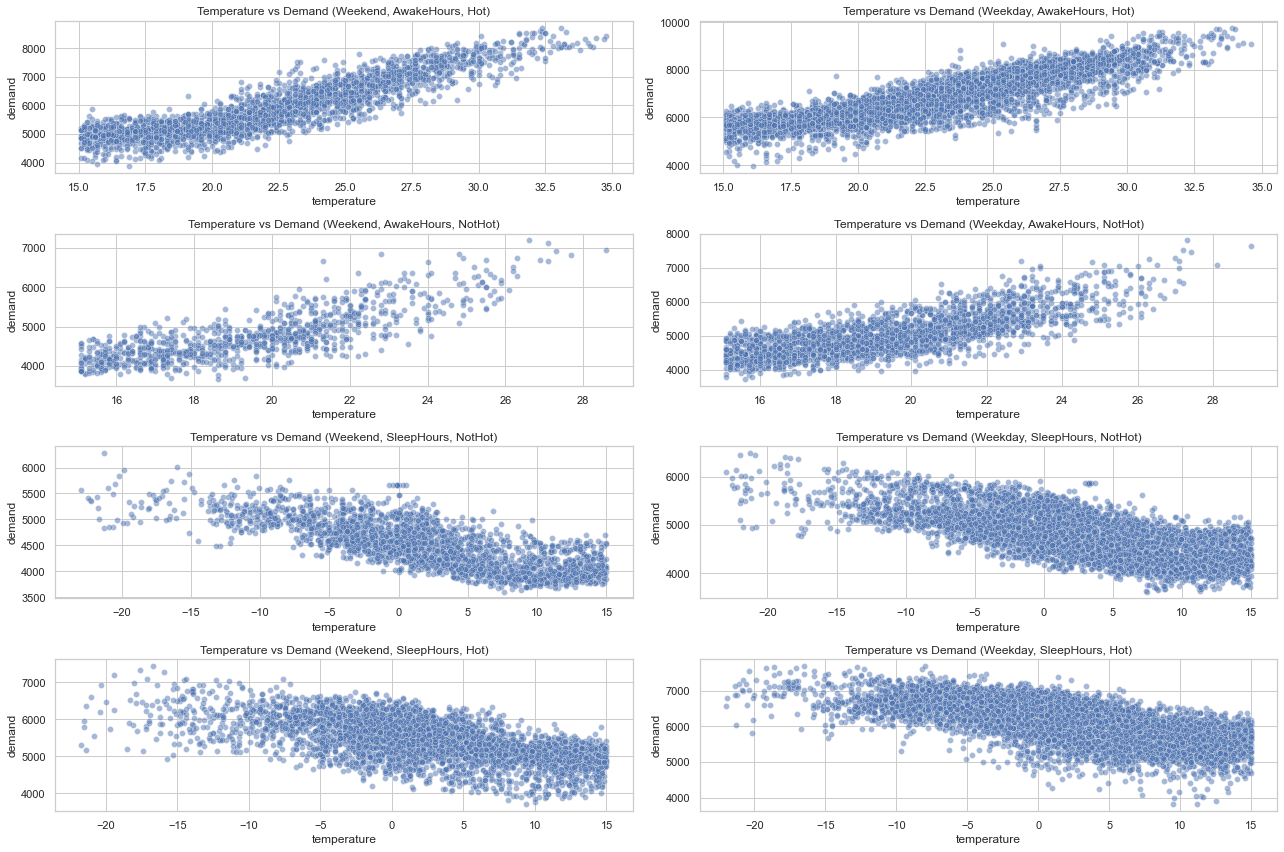

In [20]:
fig, axes = plt.subplots(nrows=4, ncols=2)

sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section1"'),ax=axes[0,0], alpha = 0.5);
axes[0,0].set_title('Temperature vs Demand (Weekend, AwakeHours, Hot)');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section2"'),ax=axes[0,1], alpha = 0.5);
axes[0,1].set_title('Temperature vs Demand (Weekday, AwakeHours, Hot)');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section3"'),ax=axes[3,0], alpha = 0.5);
axes[1,0].set_title('Temperature vs Demand (Weekend, AwakeHours, NotHot)');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section4"'),ax=axes[3,1], alpha = 0.5);
axes[1,1].set_title('Temperature vs Demand (Weekday, AwakeHours, NotHot)');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section5"'),ax=axes[2,0], alpha = 0.5);
axes[2,0].set_title('Temperature vs Demand (Weekend, SleepHours, NotHot)');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section6"'),ax=axes[2,1], alpha = 0.5);
axes[2,1].set_title('Temperature vs Demand (Weekday, SleepHours, NotHot)');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section7"'),ax=axes[1,0], alpha = 0.5);
axes[3,0].set_title('Temperature vs Demand (Weekend, SleepHours, Hot)');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section8"'),ax=axes[1,1], alpha = 0.5);
axes[3,1].set_title('Temperature vs Demand (Weekday, SleepHours, Hot)');

fig.tight_layout();

We can now see a further stronger linear relationship in each of these sections and the pearson coefficients are shown below. 

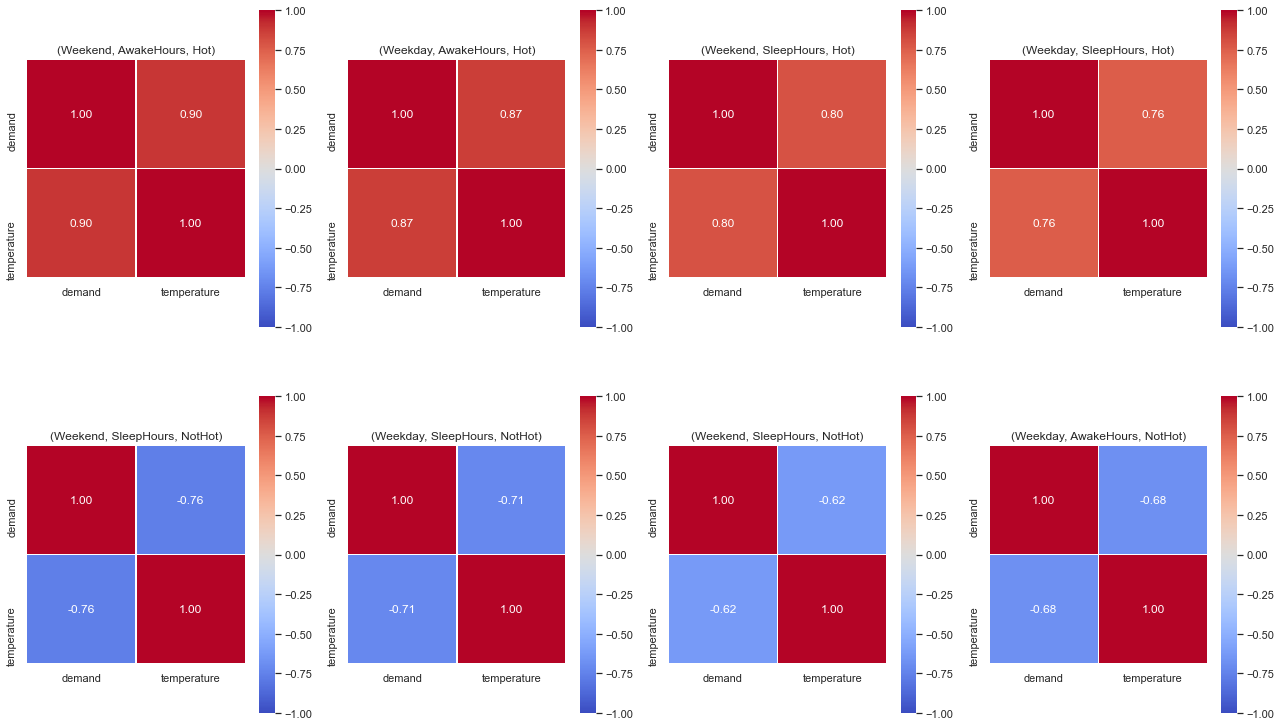

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=4)

sns.heatmap(data.query('sections_1 == "Section1"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0,0]);
axes[0,0].set_title('(Weekend, AwakeHours, Hot)');
sns.heatmap(data.query('sections_1 == "Section2"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0,1]);
axes[0,1].set_title('(Weekday, AwakeHours, Hot)');
sns.heatmap(data.query('sections_1 == "Section3"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1,2]);
axes[1,2].set_title('(Weekend, SleepHours, NotHot)');
sns.heatmap(data.query('sections_1 == "Section4"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1,3]);
axes[1,3].set_title('(Weekday, AwakeHours, NotHot)');
sns.heatmap(data.query('sections_1 == "Section5"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1,0]);
axes[1,0].set_title('(Weekend, SleepHours, NotHot)');
sns.heatmap(data.query('sections_1 == "Section6"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1,1]);
axes[1,1].set_title('(Weekday, SleepHours, NotHot)');
sns.heatmap(data.query('sections_1 == "Section7"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0,2]);
axes[0,2].set_title('(Weekend, SleepHours, Hot)');
sns.heatmap(data.query('sections_1 == "Section8"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0,3]);
axes[0,3].set_title('(Weekday, SleepHours, Hot)');

fig.tight_layout();

We can now split the dataset into a training set and a forecast set. We can use the data points from 2017 to 2020, to predict the first 18 days (=18$*$24 points). 

In [22]:
data_21 = data.loc['2021']
data_17_20 = data.loc['2017':'2020']

In [23]:
def predict(data,group_by,ridge_coef):
    """
    Given, a data point, the groups by which we split and the regression coefficients, this function returns a prediction
    """
    group = tuple(data[group_by])
    idx = groupby_list.index(group)
    (inter,slope) = ridge_coef[idx]
    return inter + slope*data['temperature']

def RMSE_error(data,forecast):
    """
    This function gives the RMSE for the forecats
    """
    return np.sqrt((1/data.shape[0])*np.sum(np.square(data-forecast)))

def baseline_model(data_1,data,i):
    """
    Defines a baseline model for 2021 forecast, based on 2020 datapoints
    """
    return data.loc['2020'].iloc[i]['demand']

def baseline_model_1(data_1,data,i):
    """
    Defines a baseline model for 2021 forecast, based on 2020 datapoints shifted to match the weekends
    """
    if i == 0:
        return data.loc['2020'].iloc[i]['demand']
    else:
        return data.loc['2020'].iloc[i+48]['demand']


def pred_interval(prediction,test_data,test_predictions,alpha=0.95):
    """
    Obtain the prediction interval for each of the prediction
    Input: single prediction, entire test data, test set predictions
    Output: Prediction intervals and the actual prediction
    """
    y_test = test_data['demand']
    test_predictions = np.array(test_predictions)
    err = np.sum(np.square((y_test - test_predictions)))
    std = np.sqrt((1 / (y_test.shape[0] - 2)) * err)
    z = stats.norm.ppf(1 - (1-alpha)/2)
    interval = z*std
    
    return [float(prediction-interval),float(prediction),float(prediction+interval)]

### Baseline Model

In [24]:
demand_hat = []
for i in range(data_21.shape[0]):
    demand_hat.append(baseline_model(data_21.iloc[i],data,i))
print(f"The RMSE is: {RMSE_error(data_21['demand'],demand_hat)}")
display(RMSE_error(data_21['demand'],demand_hat)*100/data_21['demand'].mean())

The RMSE is: 519.362035203875


9.241237418784436

In [25]:
prediction_interval = []
for i in range(data_21.shape[0]):
    prediction_interval.append(pred_interval(demand_hat[i],data_21,demand_hat))
pred_int = pd.DataFrame(prediction_interval,columns=['Lower','Actual','Upper'])
display(pred_int.head())

Lower  Actual        Upper
0  3697.704581  4718.0  5738.295419
1  3550.704581  4571.0  5591.295419
2  3422.704581  4443.0  5463.295419
3  3335.704581  4356.0  5376.295419
4  3296.704581  4317.0  5337.295419

In [26]:
df = pd.DataFrame({'time':data_21.index,'predictions':demand_hat})

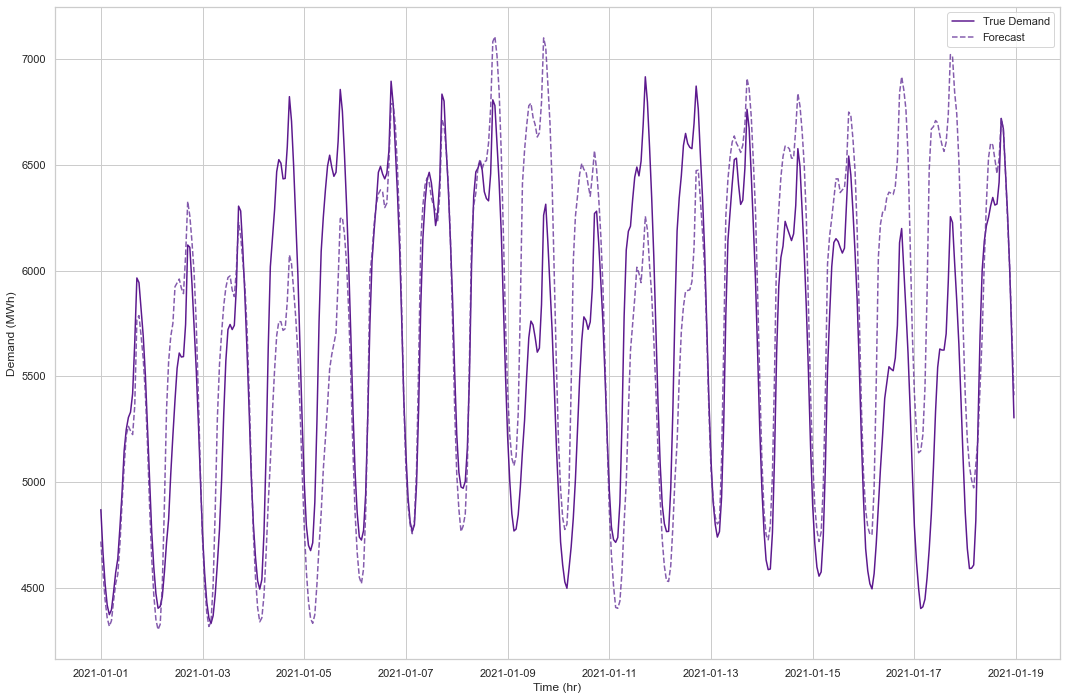

In [27]:
sns.lineplot(x = 'timestamp', y = 'demand', data = data_21.reset_index(), label='True Demand',color="indigo",alpha=0.9);
sns.lineplot(x = 'time', y = 'predictions', data = df,label='Forecast', color="rebeccapurple",linestyle='dashed',alpha=0.8);
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

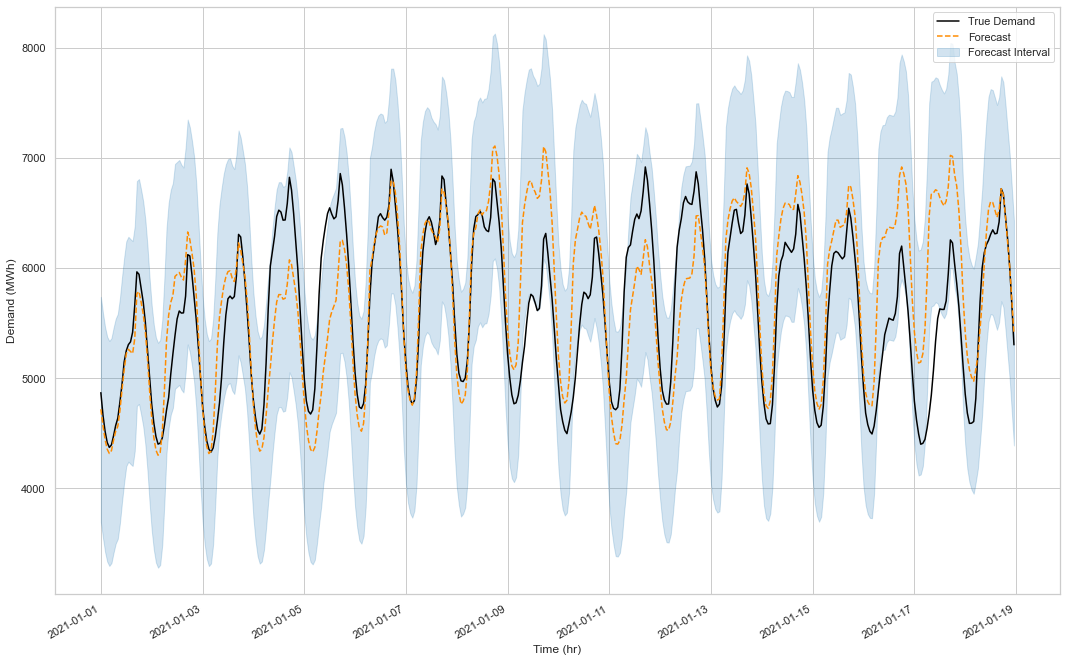

In [28]:
sns.lineplot(x = 'timestamp', y = 'demand', data = data_21.reset_index(), label='True Demand',color="black");
sns.lineplot(x = 'timestamp', y = 'Actual',  data = pred_int.set_index(data_21.index).reset_index(),label='Forecast',color="darkorange",linestyle='dashed')
plt.fill_between(df['time'],pred_int['Lower'],pred_int['Upper'],label='Forecast Interval',color="tab:blue",alpha=0.2);
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

### Baseline model 1

In [29]:
demand_hat_0 = []
for i in range(data_21.shape[0]):
    demand_hat_0.append(baseline_model_1(data_21.iloc[i],data,i))
print(f"The RMSE is: {RMSE_error(data_21['demand'],demand_hat_0)}")

The RMSE is: 347.701210731922


In [30]:
display(RMSE_error(data_21['demand'],demand_hat_0)*100/data_21['demand'].mean())

6.18680076973889

In [31]:
prediction_interval_0 = []
for i in range(data_21.shape[0]):
    prediction_interval_0.append(pred_interval(demand_hat_0[i],data_21,demand_hat_0))
pred_int_0 = pd.DataFrame(prediction_interval_0,columns=['Lower','Actual','Upper'])
display(pred_int_0.head())

Lower  Actual        Upper
0  4034.935147  4718.0  5401.064853
1  3832.935147  4516.0  5199.064853
2  3697.935147  4381.0  5064.064853
3  3632.935147  4316.0  4999.064853
4  3655.935147  4339.0  5022.064853

In [32]:
df_0 = pd.DataFrame({'time':data_21.index,'predictions':demand_hat_0})

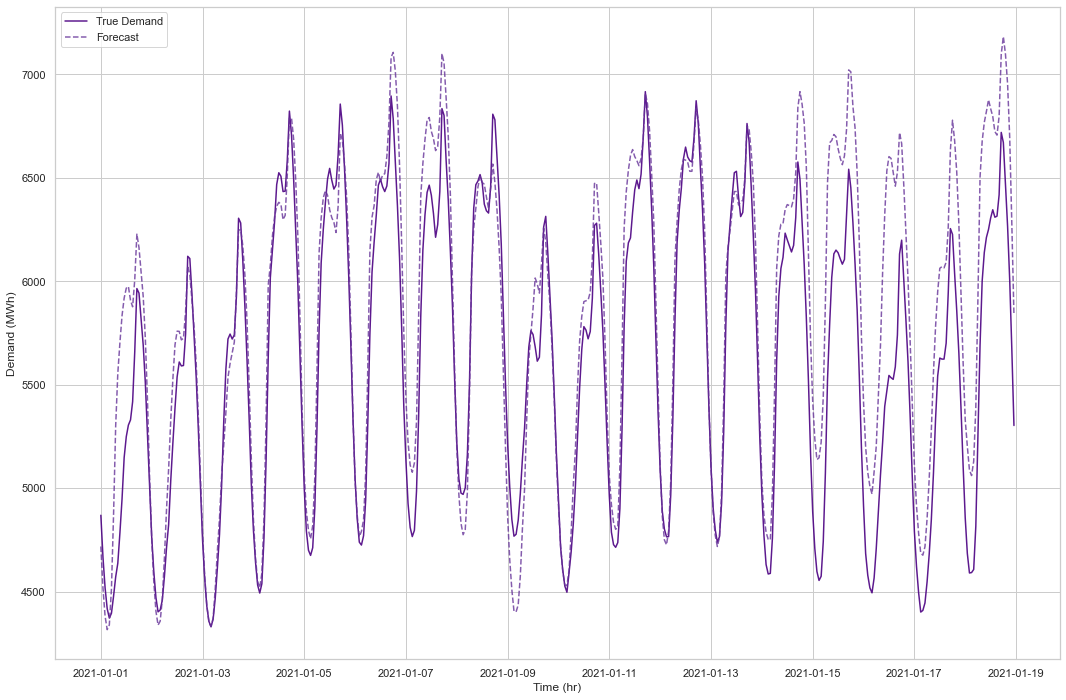

In [33]:
sns.lineplot(x = 'timestamp', y = 'demand', data = data_21.reset_index(), label='True Demand',color="indigo",alpha=0.9);
sns.lineplot(x = 'time', y = 'predictions', data = df_0,label='Forecast', color="rebeccapurple",linestyle='dashed',alpha=0.8);
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

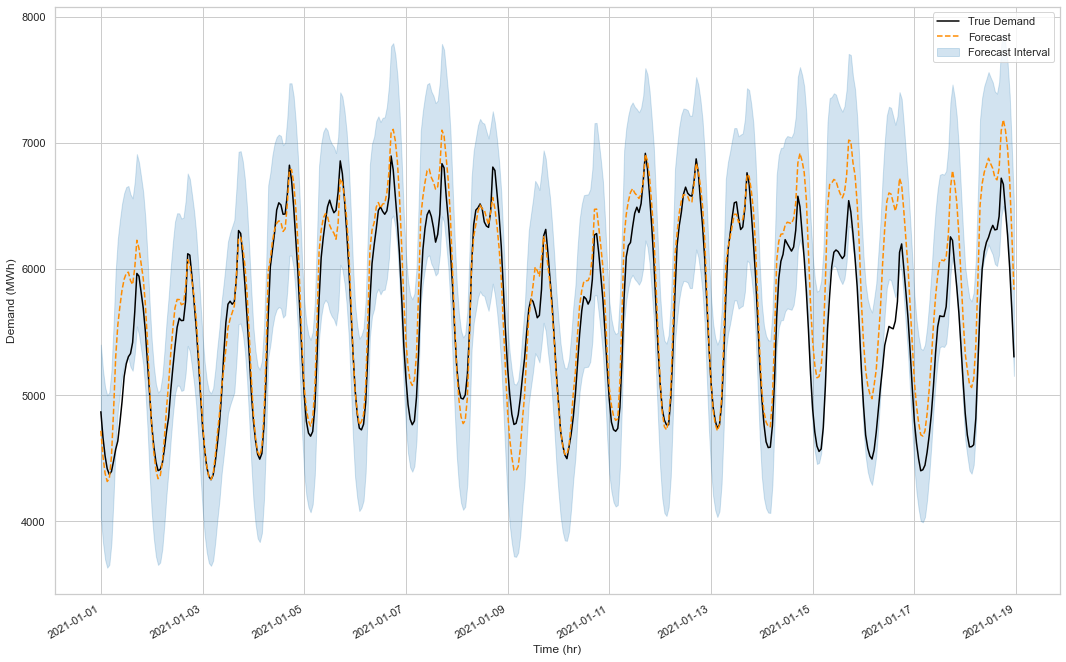

In [34]:
sns.lineplot(x = 'timestamp', y = 'demand', data = data_21.reset_index(), label='True Demand',color="black");
sns.lineplot(x = 'timestamp', y = 'Actual',  data = pred_int_0.set_index(data_21.index).reset_index(),label='Forecast',color="darkorange",linestyle='dashed')
plt.fill_between(df['time'],pred_int_0['Lower'],pred_int_0['Upper'],label='Forecast Interval',color="tab:blue",alpha=0.2);
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

In [35]:
def Ridge_error(data):
    """
    Based on the provided data, this function returns the training error while performing ridge regression
    """
    x = data['temperature'].values.reshape(-1,1)
    y = data['demand'].values.reshape(-1,1)
    model = Ridge().fit(x,y)
    train_error = np.sqrt((1/y.shape[0])*np.sum(np.square(np.squeeze(model.predict(x)) - y.T)))
    return (round(float(train_error),3))

def Ridge_model(data):
    """
    Based on the provided data, this function returns the 
    coefficients of the ridge regression.
    
    input: the training data
    output: ridge regression coefficients
    
    """
    data = data.sample(frac=1,random_state=42)
    x = data['temperature'].values.reshape(-1,1)
    y = data['demand'].values.reshape(-1,1)
    model = Ridge().fit(x, y)
    return (round(float(model.intercept_),3),round(float(model.coef_),3))   

### Model with two categories 
#### ("AwakeHours" and  "SleepHours")
Here, we train a linear model with two categories for each of the eight sections

In [36]:
num = data_17_20['temp_index'].nunique()*data_17_20['hour_index'].nunique()*data_17_20['week_index'].nunique()

Train_error = np.zeros((num,1))

for i in range(1,num+1):
    train = data_17_20.groupby('sections_1').apply(Ridge_error)['Section'+str(i)]
    Train_error[i-1] = train

print(Train_error.mean())

389.64212499999996


The coefficients of regression in each of the category is shown below.

In [37]:
start = time.time()

ridge_coef_1= data_17_20.groupby(['temp_index','hour_index','week_index']).apply(Ridge_model)
display(pd.DataFrame(ridge_coef_1,columns=['Regression Coefficients (Intercept,Slope)']))

end = time.time()
print(end - start)

Regression Coefficients (Intercept,Slope)
temp_index hour_index week_index                                          
Hot        AwakeHours Weekday                          (2365.358, 195.827)
                      Weekend                            (1464.69, 199.65)
           SleepHours Weekday                          (1662.604, 173.557)
                      Weekend                          (1214.835, 181.721)
NotHot     AwakeHours Weekday                          (6261.828, -51.106)
                      Weekend                          (5570.251, -49.674)
           SleepHours Weekday                          (4876.918, -47.339)
                      Weekend                          (4588.637, -46.312)

0.0624852180480957


In [38]:
groupby_list = list(data.groupby(['temp_index','hour_index','week_index']).groups.keys())

In [39]:
demand_hat_1 = []
for i in range(data_21.shape[0]):
    demand_hat_1.append(predict(data_21.iloc[i],['temp_index','hour_index','week_index'],ridge_coef_1))
print(f"The RMSE is: {RMSE_error(data_21['demand'],demand_hat_1)}")

The RMSE is: 344.08512047704585


In [40]:
display(RMSE_error(data_21['demand'],demand_hat_1)*100/data_21['demand'].mean())

6.122458083312175

In [41]:
prediction_interval_1 = []
for i in range(data_21.shape[0]):
    prediction_interval_1.append(pred_interval(demand_hat_1[i],data_21,demand_hat_1))
pred_int_1 = pd.DataFrame(prediction_interval_1,columns=['Lower','Actual','Upper'])
display(pred_int_1.head())

Lower     Actual        Upper
0  4023.824817  4699.7858  5375.746783
1  4000.668817  4676.6298  5352.590783
2  4019.193617  4695.1546  5371.115583
3  4074.768017  4750.7290  5426.689983
4  4060.874417  4736.8354  5412.796383

In [42]:
df_1 = pd.DataFrame({'time':data_21.index,'predictions':demand_hat_1})

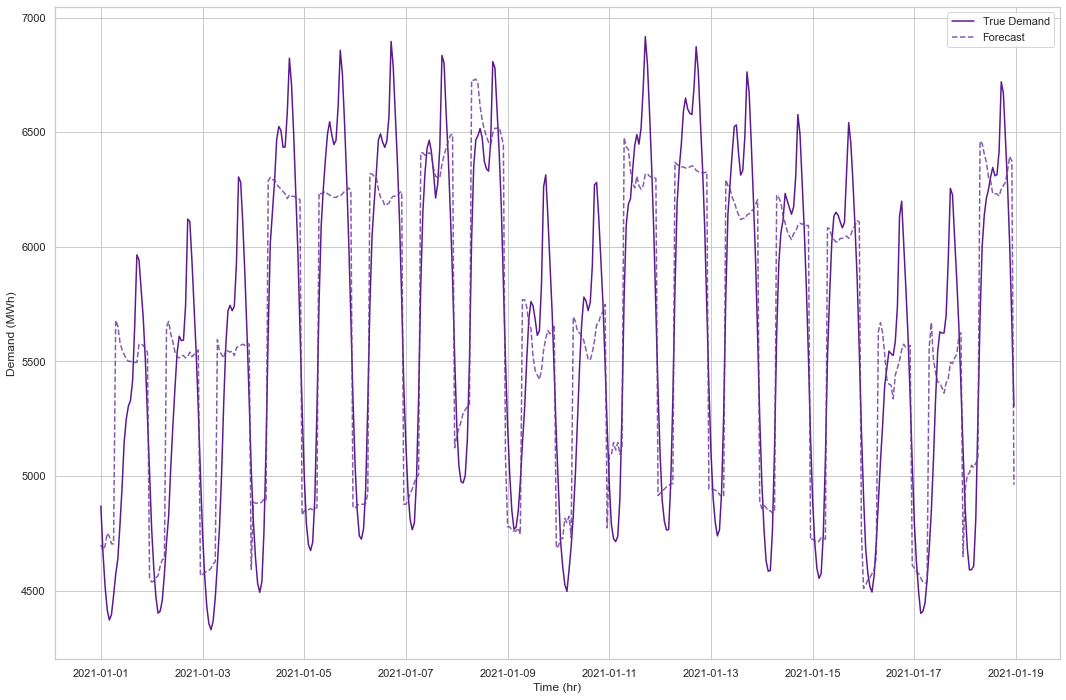

In [43]:
sns.lineplot(x = 'timestamp', y = 'demand', data = data_21.reset_index(), label='True Demand',color="indigo",alpha=0.9);
sns.lineplot(x = 'time', y = 'predictions', data = df_1,label='Forecast', color="rebeccapurple",linestyle='dashed',alpha=0.8);
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

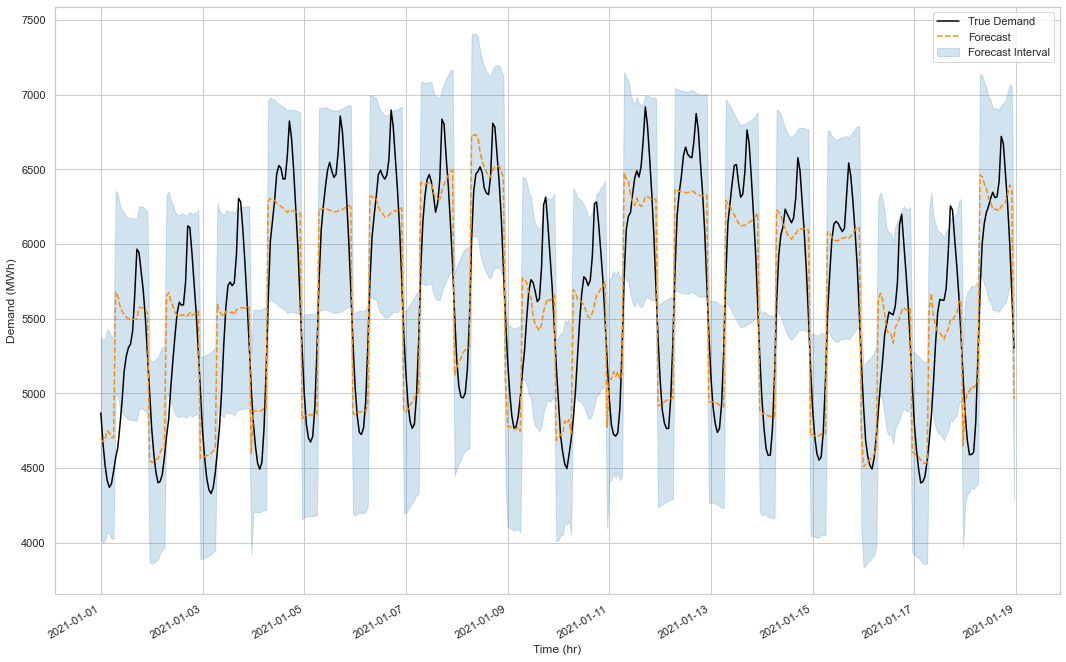

In [44]:
sns.lineplot(x = 'timestamp', y = 'demand', data = data_21.reset_index(), label='True Demand',color="black");
sns.lineplot(x = 'timestamp', y = 'Actual',  data = pred_int_1.set_index(data_21.index).reset_index(),label='Forecast',color="darkorange",linestyle='dashed')
plt.fill_between(df['time'],pred_int_1['Lower'],pred_int_1['Upper'],label='Forecast Interval',color="tab:blue",alpha=0.2);
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

### Model with five categories 
#### ("EarlyMorning", "Morning", "Noon", "Evening" and "Night")
Here, we train a linear model with five categories. Therefore, we would have 2$*$2$*$5 = 20 sections. Of course we would;t be plotting all the 20 sections.

In [45]:
def peak_1(x):
    """
    Defining five categories based on the hour of the day
    """
    if x >= 0 and x <=6:
        return 'EarlyMorning'
    elif x > 6 and x <=10: 
        return 'Morning'
    elif x > 10 and x <=15:
        return 'Noon'
    elif x > 15 and x <=20:
        return 'Evening'
    elif x > 20 and x <=23:
        return 'Night'

In [46]:
data['hour_index_1'] = data['hour'].apply(peak_1)
display(data.head())

temperature  demand  year  month  dayofweek  day  hour  \
timestamp                                                                     
2017-01-01 00:00:00          0.5    5665  2017      1          6    1     0   
2017-01-01 01:00:00          0.3    5665  2017      1          6    1     1   
2017-01-01 02:00:00          0.0    5665  2017      1          6    1     2   
2017-01-01 03:00:00         -0.1    5665  2017      1          6    1     3   
2017-01-01 04:00:00         -0.1    5665  2017      1          6    1     4   

                    temp_index  hour_index week_index dst_index  sections  \
timestamp                                                                   
2017-01-01 00:00:00     NotHot  SleepHours    Weekend     NoDST  Section3   
2017-01-01 01:00:00     NotHot  SleepHours    Weekend     NoDST  Section3   
2017-01-01 02:00:00     NotHot  SleepHours    Weekend     NoDST  Section3   
2017-01-01 03:00:00     NotHot  SleepHours    Weekend     NoDST  Section3   
2017-01-01 04:00:00     NotHot  SleepHours    Weekend     NoDST  Section3   

                    sections_1  hour_index_1  
timestamp                                     
2017-01-01 00:00:00   Section5  EarlyMorning  
2017-01-01 01:00:00   Section5  EarlyMorning  
2017-01-01 02:00:00   Section5  EarlyMorning  
2017-01-01 03:00:00   Section5  EarlyMorning  
2017-01-01 04:00:00   Section5  EarlyMorning

A scatter plot of temperature vs demand showing all the five categories.

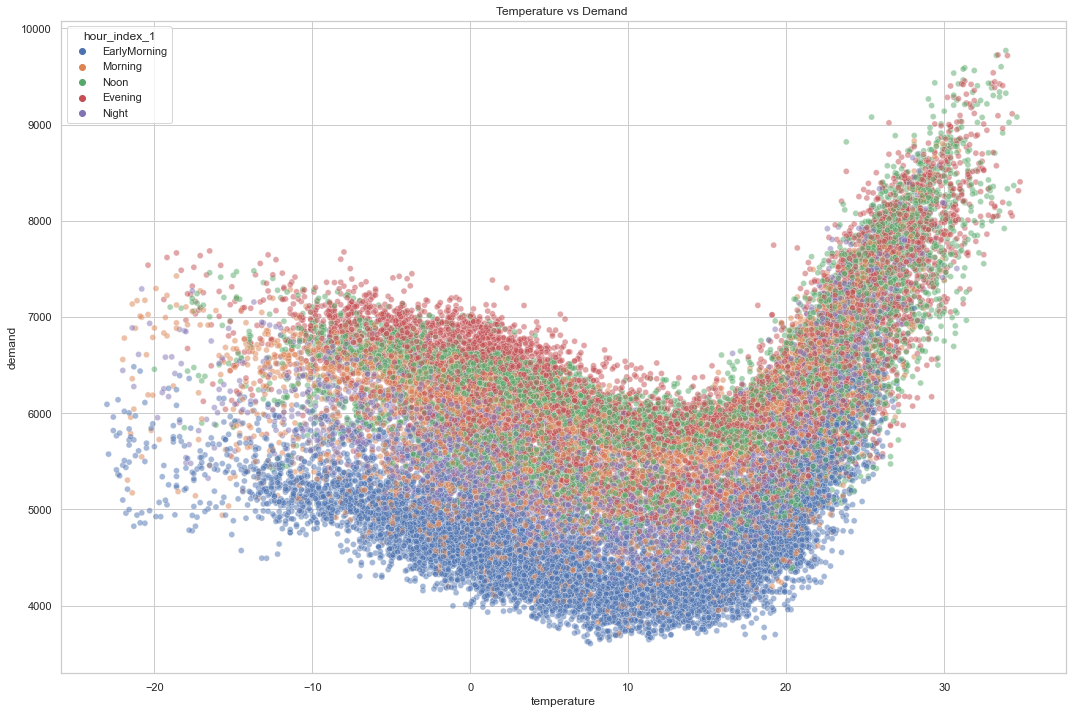

In [47]:
sns.scatterplot(x='temperature',y='demand',hue='hour_index_1',data=data, alpha = 0.5);
plt.title('Temperature vs Demand ');

This plot shows, how for each of the categorythe temperature dision makes it linear in each of them

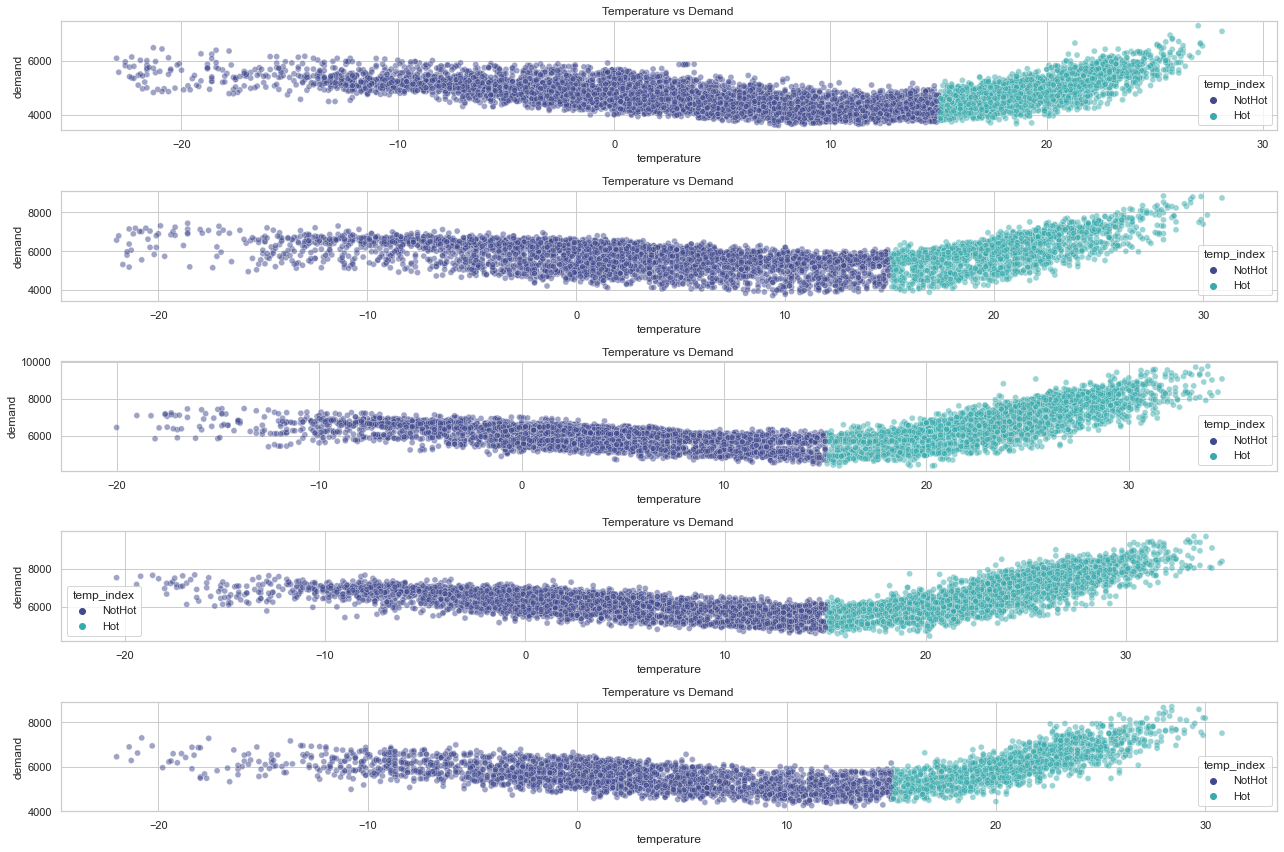

In [48]:
fig, axes = plt.subplots(nrows=5, ncols=1)

sns.scatterplot(x='temperature',y='demand',data=data.query('hour_index_1 == "EarlyMorning"'),hue='temp_index',ax=axes[0],palette="mako", alpha = 0.5);
axes[0].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('hour_index_1 == "Morning"'),hue='temp_index',ax=axes[1],palette="mako", alpha = 0.5);
axes[1].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('hour_index_1 == "Noon"'),hue='temp_index',ax=axes[2],palette="mako", alpha = 0.5);
axes[2].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('hour_index_1 == "Evening"'),hue='temp_index',ax=axes[3],palette="mako", alpha = 0.5);
axes[3].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('hour_index_1 == "Night"'),hue='temp_index',ax=axes[4],palette="mako", alpha = 0.5);
axes[4].set_title('Temperature vs Demand ');

fig.tight_layout()

In [49]:
data_21 = data.loc['2021']
data_17_20 = data.loc['2017':'2020']

groupby_list = list(data.groupby(['temp_index','hour_index_1','week_index']).groups.keys())

The regression coefficient for each of the category is displayed below

In [50]:
start = time.time()

ridge_coef_2 = data_17_20.groupby(['temp_index','hour_index_1','week_index']).apply(Ridge_model)
display(pd.DataFrame(ridge_coef_2,columns=['Regression Coefficients (Intercept,Slope)']))

end = time.time()
print(end - start)

Regression Coefficients (Intercept,Slope)
temp_index hour_index_1 week_index                                          
Hot        EarlyMorning Weekday                          (1914.348, 155.926)
                        Weekend                          (1500.448, 162.743)
           Evening      Weekday                          (2496.773, 191.537)
                        Weekend                           (1783.38, 190.872)
           Morning      Weekday                          (2460.782, 187.531)
                        Weekend                          (1268.144, 196.002)
           Night        Weekday                          (1736.852, 214.306)
                        Weekend                          (1536.099, 201.137)
           Noon         Weekday                          (2494.232, 191.707)
                        Weekend                          (1541.159, 195.299)
NotHot     EarlyMorning Weekday                          (4817.343, -47.346)
                        Weekend                          (4527.757, -46.631)
           Evening      Weekday                          (6505.188, -60.147)
                        Weekend                          (5940.773, -61.529)
           Morning      Weekday                          (6054.418, -48.199)
                        Weekend                           (5110.244, -47.65)
           Night        Weekday                          (5736.934, -47.046)
                        Weekend                           (5354.633, -47.08)
           Noon         Weekday                          (6362.056, -50.556)
                        Weekend                           (5679.52, -50.144)

0.06895303726196289


In [51]:
num = data['temp_index'].nunique()*data['hour_index_1'].nunique()*data['week_index'].nunique()

Train_error = np.zeros((num,1))

for i in range(1,num+1):
    train = data_17_20.groupby(['temp_index','hour_index_1','week_index']).apply(Ridge_error)[i-1]
    Train_error[i-1] = train
    
print(Train_error.mean())

359.51924999999994


In [52]:
demand_hat_2 = []
for i in range(data_21.shape[0]):
    demand_hat_2.append(predict(data_21.iloc[i],['temp_index','hour_index_1','week_index'],ridge_coef_2))
print(f"The RMSE is: {RMSE_error(data_21['demand'],demand_hat_2)}")

The RMSE is: 222.325575940935


In [53]:
display(RMSE_error(data_21['demand'],demand_hat_2)*100/data_21['demand'].mean())

3.9559368846274117

In [54]:
prediction_interval_2 = []
for i in range(data_21.shape[0]):
    prediction_interval_2.append(pred_interval(demand_hat_2[i],data_21,demand_hat_2))
pred_int_2 = pd.DataFrame(prediction_interval_2,columns=['Lower','Actual','Upper'])
display(pred_int_2.head())

Lower     Actual        Upper
0  4202.909082  4639.6714  5076.433718
1  4179.593582  4616.3559  5053.118218
2  4198.245982  4635.0083  5071.770618
3  4254.203182  4690.9655  5127.727818
4  4240.213882  4676.9762  5113.738518

In [55]:
df_2 = pd.DataFrame({'time':data_21.index,'predictions':demand_hat_2})

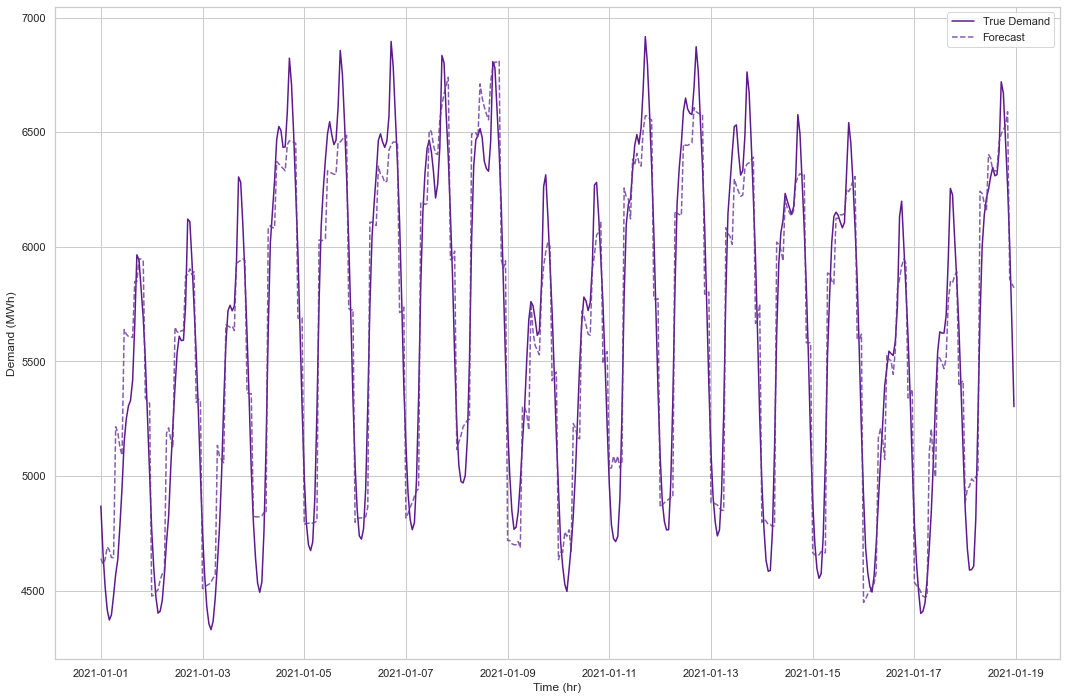

In [56]:
sns.lineplot(x = 'timestamp', y = 'demand', data = data_21.reset_index(), label='True Demand',color="indigo",alpha=0.9);
sns.lineplot(x = 'time', y = 'predictions', data = df_2,label='Forecast', color="rebeccapurple",linestyle='dashed',alpha=0.8);
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

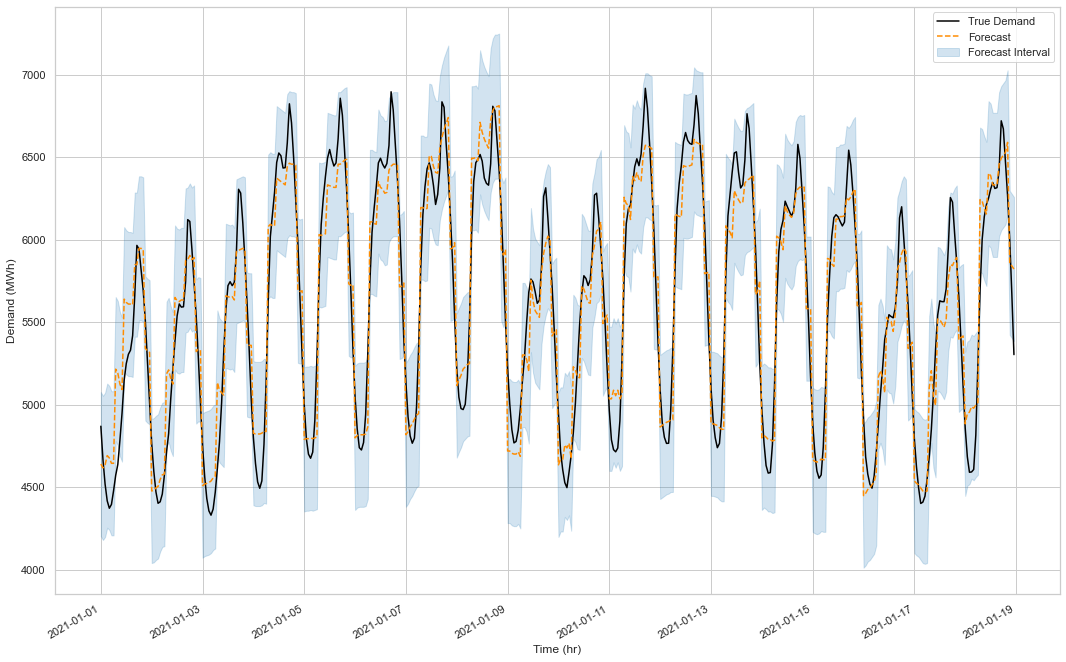

In [57]:
sns.lineplot(x = 'timestamp', y = 'demand', data = data_21.reset_index(), label='True Demand',color="black");
sns.lineplot(x = 'timestamp', y = 'Actual',  data = pred_int_2.set_index(data_21.index).reset_index(),label='Forecast',color="darkorange",linestyle='dashed')
plt.fill_between(df['time'],pred_int_2['Lower'],pred_int_2['Upper'],label='Forecast Interval',color="tab:blue",alpha=0.2);
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

### Model with 24 categories 
#### One for each hour of the day
Here, we train a linear model with 24 categories. Therefore, we would have 2$*$2$*$24 = 96 sections. Therefore, we end up with 96 ridge regression models.

In [58]:
groupby_list = list(data.groupby(['temp_index','hour','week_index']).groups.keys())

In [59]:
start = time.time()

ridge_coef_3 = data_17_20.groupby(['temp_index','hour','week_index']).apply(Ridge_model)
display(pd.DataFrame(ridge_coef_3,columns=['Regression Coefficients (Intercept,Slope)']))

end = time.time()
print(end - start)

Regression Coefficients (Intercept,Slope)
temp_index hour week_index                                          
Hot        0    Weekday                           (1619.64, 182.657)
                Weekend                          (1662.488, 173.253)
           1    Weekday                           (1699.014, 166.95)
                Weekend                          (1577.315, 165.893)
           2    Weekday                          (1751.757, 156.142)
...                                                              ...
NotHot     21   Weekend                          (5650.532, -48.601)
           22   Weekday                          (5756.672, -47.329)
                Weekend                          (5371.488, -47.173)
           23   Weekday                          (5325.598, -46.663)
                Weekend                          (5053.002, -47.484)

[96 rows x 1 columns]

0.17147541046142578


In [60]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame(ridge_coef_3, columns=['Coefficients']))

                                   Coefficients
temp_index hour week_index                     
Hot        0    Weekday      (1619.64, 182.657)
                Weekend     (1662.488, 173.253)
           1    Weekday      (1699.014, 166.95)
                Weekend     (1577.315, 165.893)
           2    Weekday     (1751.757, 156.142)
                Weekend     (1647.136, 153.942)
           3    Weekday       (1873.1, 146.133)
                Weekend     (1626.399, 148.095)
           4    Weekday     (2082.573, 136.167)
                Weekend     (1770.307, 138.383)
           5    Weekday     (2330.876, 132.532)
                Weekend     (1821.999, 137.095)
           6    Weekday     (2707.417, 133.147)
                Weekend     (2031.385, 130.482)
           7    Weekday     (2971.202, 145.854)
                Weekend     (1951.432, 144.053)
           8    Weekday     (2964.886, 161.215)
                Weekend      (1598.284, 174.52)
           9    Weekday     (2789.689, 1

The mean count is: 365.25
The min count is: 105
The max count is: 761


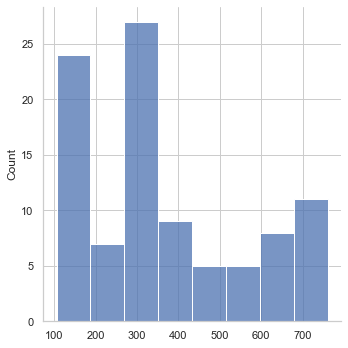

In [61]:
count_group = np.array(data_17_20.groupby(['temp_index','hour','week_index'])['demand'].count())
print(f"The mean count is: {count_group.mean()}")
print(f"The min count is: {count_group.min()}")
print(f"The max count is: {count_group.max()}")
sns.displot(count_group);

In [62]:
num = data['temp_index'].nunique()*data['hour'].nunique()*data['week_index'].nunique()

Train_error = np.zeros((num,1))

for i in range(1,num+1):
    train = data_17_20.groupby(['temp_index','hour','week_index']).apply(Ridge_error)[i-1]
    Train_error[i-1] = train

print(Train_error.mean())

302.48826041666666


In [63]:
demand_hat_3 = []
for i in range(data_21.shape[0]):
    demand_hat_3.append(predict(data_21.iloc[i],['temp_index','hour','week_index'],ridge_coef_3))
print(f"The RMSE is: {RMSE_error(data_21['demand'],demand_hat_3)}")

The RMSE is: 140.04972981679936


In [64]:
display(RMSE_error(data_21['demand'],demand_hat_3)*100/data_21['demand'].mean())

2.4919665203591688

In [65]:
prediction_interval_3 = []
for i in range(data_21.shape[0]):
    prediction_interval_3.append(pred_interval(demand_hat_3[i],data_21,demand_hat_3))
pred_int_3 = pd.DataFrame(prediction_interval_3,columns=['Lower','Actual','Upper'])
display(pred_int_3.head())

Lower     Actual       Upper
0  4675.03496  4950.1650  5225.29504
1  4437.40616  4712.5362  4987.66624
2  4314.60156  4589.7316  4864.86164
3  4289.73446  4564.8645  4839.99454
4  4252.86236  4527.9924  4803.12244

In [66]:
df_3 = pd.DataFrame({'time':data_21.index,'predictions':demand_hat_3})

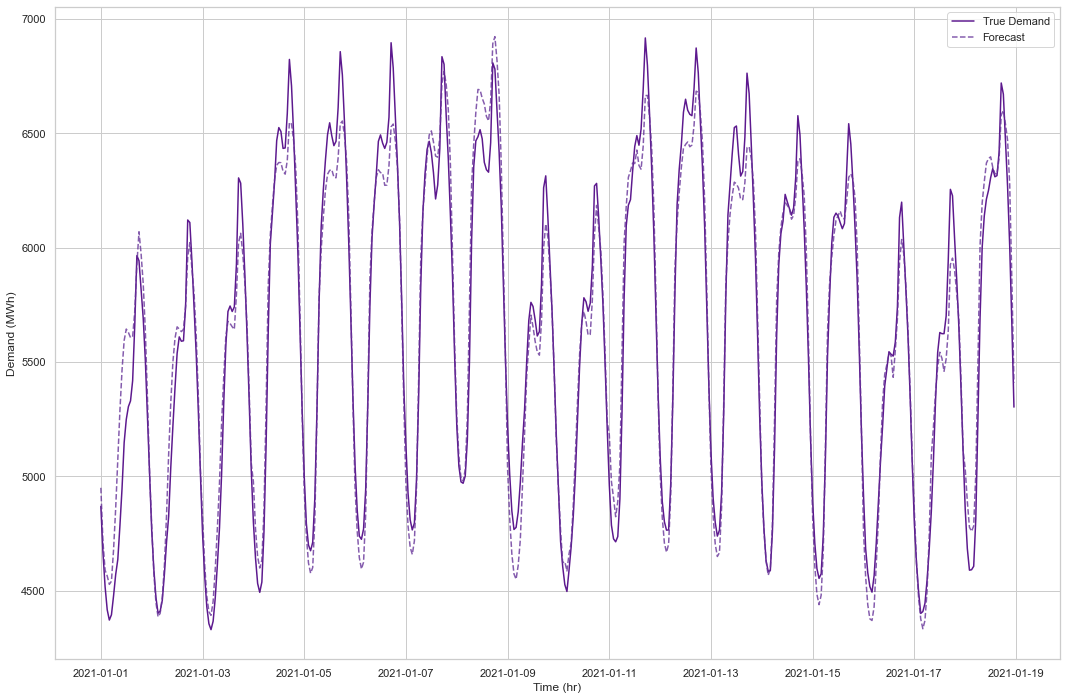

In [67]:
sns.lineplot(x = 'timestamp', y = 'demand', data = data_21.reset_index(), label='True Demand',color="indigo",alpha=0.9);
sns.lineplot(x = 'time', y = 'predictions', data = df_3,label='Forecast', color="rebeccapurple",linestyle='dashed',alpha=0.8);
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

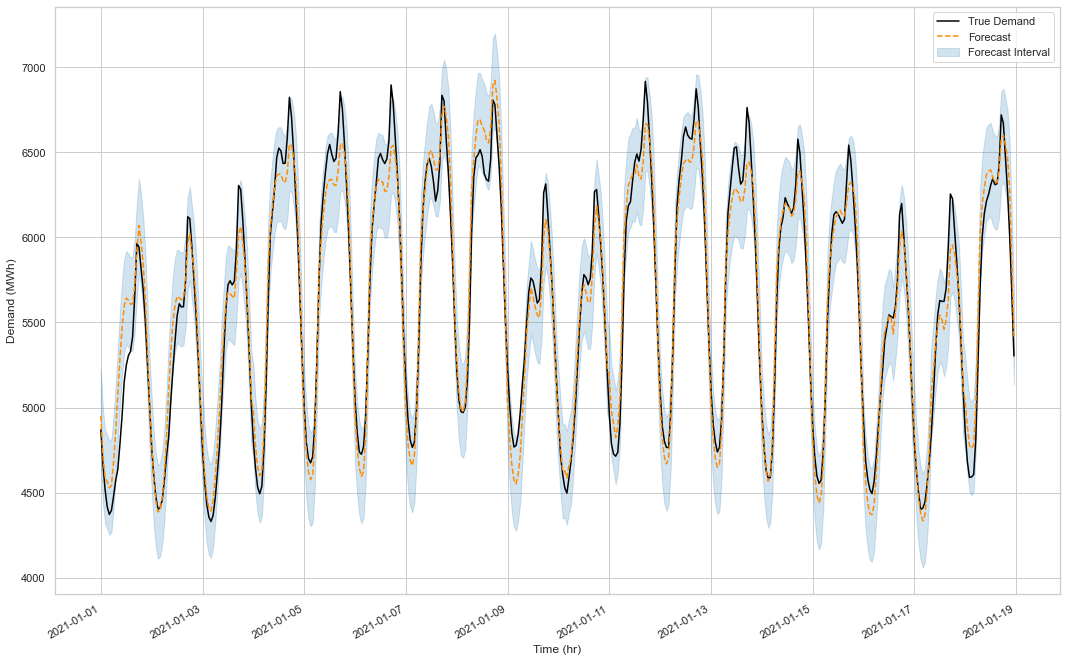

In [68]:
sns.lineplot(x = 'timestamp', y = 'demand', data = data_21.reset_index(), label='True Demand',color="black");
sns.lineplot(x = 'timestamp', y = 'Actual',  data = pred_int_3.set_index(data_21.index).reset_index(),label='Forecast',color="darkorange",linestyle='dashed')
plt.fill_between(df['time'],pred_int_3['Lower'],pred_int_3['Upper'],label='Forecast Interval',color="tab:blue",alpha=0.2);
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

### Bonus Model: Polynomial regression deg 2

In [105]:
def Ridge_error_deg2(data):
    """
    Based on the provided data, this function returns the training error while performing ridge regression
    """
    data = data.sample(frac=1,random_state=42)
    x = data['temperature'].values.reshape(-1,1)
    y = data['demand'].values.reshape(-1,1)
    model = Ridge().fit(x,y)
    train_error = np.sqrt((1/y.shape[0])*np.sum(np.square(np.squeeze(model.predict(x)) - y.T)))
    return (round(float(train_error),3))

def Ridge_model_deg2(data):
    """
    Based on the provided data, this function returns the 
    coefficients of the ridge regression.
    
    input: the training data
    output: ridge regression coefficients
    
    """
    data = data.sample(frac=1,random_state=42)
    x = data['temperature'].values.reshape(-1,1)
    y = data['demand'].values.reshape(-1,1)
    poly = PolynomialFeatures(degree=2)
    x_ = poly.fit_transform(x)
    model = Ridge().fit(x_, y)
    return (model.intercept_,model.coef_)

def predict_deg2(data,group_by,ridge_coef):
    """
    Given, a data point, the groups by which we split and the regression coefficients, this function returns a prediction
    """
    group = tuple(data[group_by])
    idx = groupby_list.index(group)
    inter,coef = ridge_coef[idx]
    x = data['temperature']
    return float(inter) + float(coef[0,0]*(x**0)) + float(coef[0,1]*(x**1)) + float(coef[0,2]*(x**2))

In [76]:
start = time.time()

ridge_coef_4 = data_17_20.groupby(['temp_index','hour','week_index']).apply(Ridge_model_deg2)
display(pd.DataFrame(ridge_coef_4,columns=['Regression Coefficients (Intercept,Slope)']))

end = time.time()
print(end - start)

Regression Coefficients (Intercept,Slope)
temp_index hour week_index                                                   
Hot        0    Weekday     ([3421.4562938485965], [[0.0, 2.05089560694625...
                Weekend     ([3450.0598077584946], [[0.0, -6.5495336120957...
           1    Weekday     ([3633.959121344608], [[0.0, -29.6140929413823...
                Weekend     ([4799.160736644428], [[0.0, -163.591735078064...
           2    Weekday     ([3857.6137759048893], [[0.0, -59.824900672160...
...                                                                       ...
NotHot     21   Weekend     ([5664.430840447992], [[0.0, -47.9833432912457...
           22   Weekday     ([5735.488358993039], [[0.0, -48.5243213735701...
                Weekend     ([5381.3091682357435], [[0.0, -46.786687168647...
           23   Weekday     ([5307.979121290535], [[0.0, -47.5556338257877...
                Weekend     ([5063.942671482198], [[0.0, -47.2040730599844...

[96 rows x 1 columns]

0.2317197322845459


In [106]:
demand_hat_4 = []
for i in range(data_21.shape[0]):
    demand_hat_4.append(predict_deg2(data_21.iloc[i],['temp_index','hour','week_index'],ridge_coef_4))
print(f"The RMSE is: {RMSE_error(data_21['demand'],demand_hat_4)}")

The RMSE is: 136.5074550189381


In [118]:
prediction_interval_4 = []
for i in range(data_21.shape[0]):
    prediction_interval_4.append(pred_interval(demand_hat_4[i],data_21,demand_hat_4))
pred_int_4 = pd.DataFrame(prediction_interval_4,columns=['Lower','Actual','Upper'])
display(pred_int_4.head())

Lower       Actual        Upper
0  4676.468737  4944.639919  5212.811102
1  4434.823811  4702.994993  4971.166175
2  4311.028988  4579.200170  4847.371352
3  4282.233492  4550.404674  4818.575857
4  4246.410805  4514.581987  4782.753170

In [108]:
df_4 = pd.DataFrame({'time':data_21.index,'predictions':demand_hat_4})

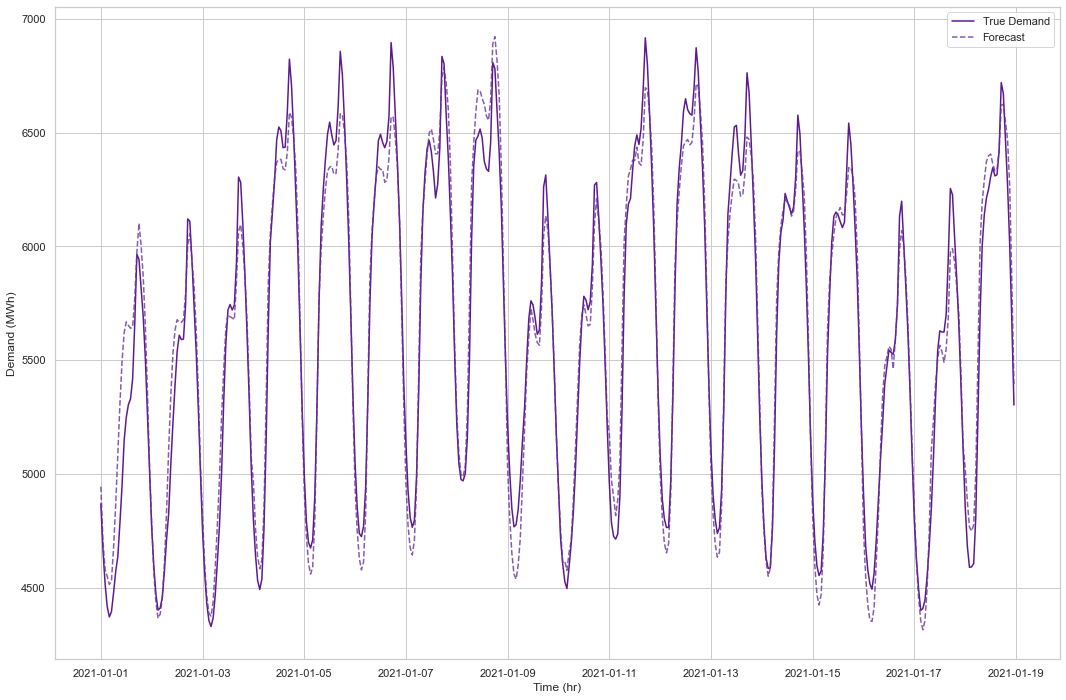

In [109]:
sns.lineplot(x = 'timestamp', y = 'demand', data = data_21.reset_index(), label='True Demand',color="indigo",alpha=0.9);
sns.lineplot(x = 'time', y = 'predictions', data = df_4,label='Forecast', color="rebeccapurple",linestyle='dashed',alpha=0.8);
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

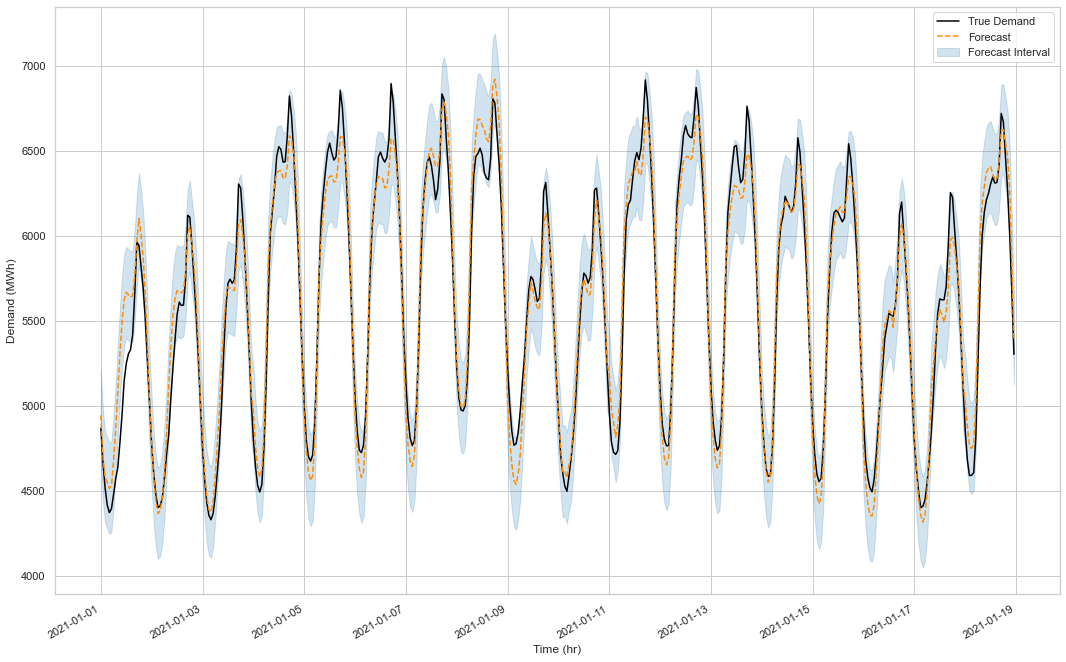

In [113]:
sns.lineplot(x = 'timestamp', y = 'demand', data = data_21.reset_index(), label='True Demand',color="black");
sns.lineplot(x = 'timestamp', y = 'Actual',  data = pred_int_4.set_index(data_21.index).reset_index(),label='Forecast',color="darkorange",linestyle='dashed')
plt.fill_between(df['time'],pred_int_4['Lower'],pred_int_4['Upper'],label='Forecast Interval',color="tab:blue",alpha=0.2);
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

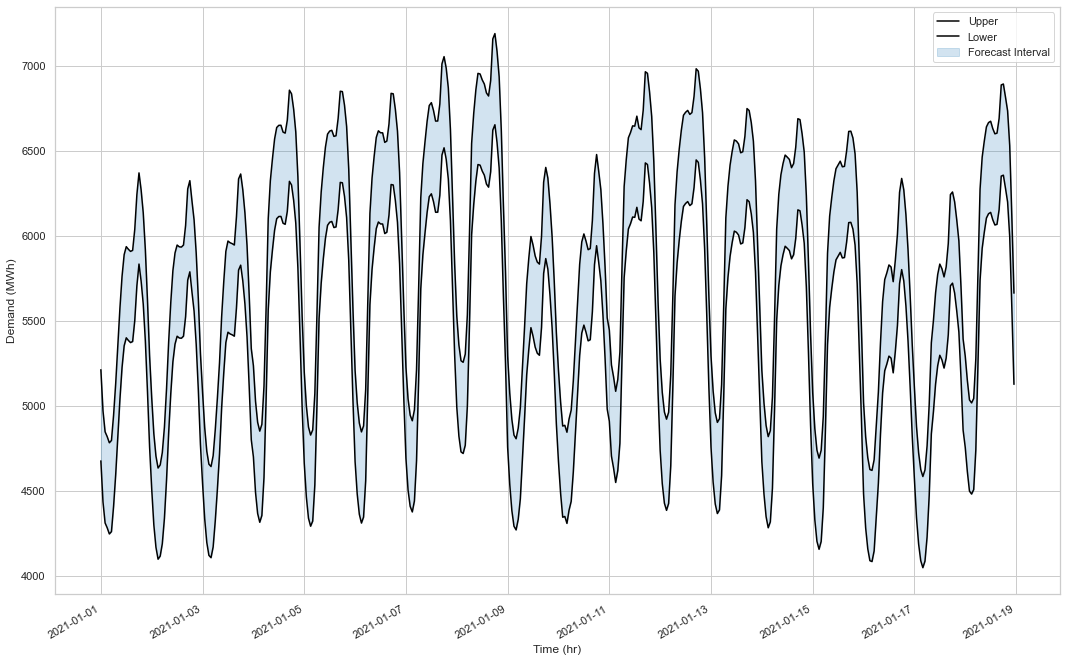

In [122]:
plt.plot(df['time'], pred_int_4['Upper'], label='Upper',color="black");
plt.plot(df['time'], pred_int_4['Lower'],label='Lower',color="black")
plt.fill_between(df['time'],pred_int_4['Lower'],pred_int_4['Upper'],label='Forecast Interval',color="tab:blue",alpha=0.2);
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

In [114]:
RMSE = [RMSE_error(data_21['demand'],demand_hat),RMSE_error(data_21['demand'],demand_hat_0),RMSE_error(data_21['demand'],demand_hat_1),RMSE_error(data_21['demand'],demand_hat_2),RMSE_error(data_21['demand'],demand_hat_3),RMSE_error(data_21['demand'],demand_hat_4)]
percent = [RMSE_error(data_21['demand'],demand_hat)*100/data_21['demand'].mean(),RMSE_error(data_21['demand'],demand_hat_0)*100/data_21['demand'].mean(),RMSE_error(data_21['demand'],demand_hat_1)*100/data_21['demand'].mean(),RMSE_error(data_21['demand'],demand_hat_2)*100/data_21['demand'].mean(),RMSE_error(data_21['demand'],demand_hat_3)*100/data_21['demand'].mean(),RMSE_error(data_21['demand'],demand_hat_4)*100/data_21['demand'].mean()]
comp = ['N/A','N/A',0.063,0.069,0.153,0.232]
Model = ['Baseline Model','Baseline Model II','Linear (8)','Linear (20)','Linear (96)', 'Polynomial degree 2 (96)']
pd.DataFrame({'Model':Model,'RMSE (MWh)':RMSE,'Percent Error (%)':percent,'Comp Time (sec)':comp})

Model  RMSE (MWh)  Percent Error (%) Comp Time (sec)
0            Baseline Model  519.362035           9.241237             N/A
1         Baseline Model II  347.701211           6.186801             N/A
2                Linear (8)  344.085120           6.122458           0.063
3               Linear (20)  222.325576           3.955937           0.069
4               Linear (96)  140.049730           2.491967           0.153
5  Polynomial degree 2 (96)  136.507455           2.428937           0.232